## **WORKING WITH DATA**

In [1]:
# Install required libraries
!pip -q install torchsummary

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchsummary import summary

import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

import os
import sys

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU {torch.cuda.get_device_name(0)} is available")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead")

GPU Tesla P100-PCIE-16GB is available


In [4]:
# Load the datasets
transforms = T.Compose([
#     T.Resize((224, 224)), 
#     T.CenterCrop(224),  These transformations have been applied already locally, see sampling_script.py
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = ImageFolder(os.path.abspath('/kaggle/input/retinal-oct-large-v1/data-balanced-latest/train'), transform=transforms)
test_data = ImageFolder(os.path.abspath('/kaggle/input/retinal-oct-large-v1/data-balanced-latest/test'), transform=transforms)

In [5]:
# Select a sample
image, target = train_data[0]

In [6]:
# Inspect sample shape
image.shape

torch.Size([3, 224, 224])

In [7]:
# Summarize training data
train_data

Dataset ImageFolder
    Number of datapoints: 108309
    Root location: /kaggle/input/retinal-oct-large-v1/data-balanced-latest/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
# Summarize test data
test_data

Dataset ImageFolder
    Number of datapoints: 498
    Root location: /kaggle/input/retinal-oct-large-v1/data-balanced-latest/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
# Class-Index relationship
train_data.class_to_idx

{'ABNORMAL': 0, 'NORMAL': 1}

Label: ABNORMAL


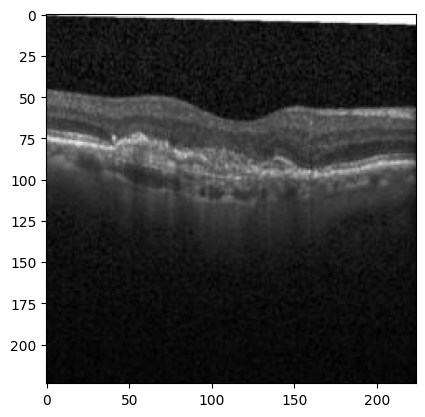

In [10]:
# Visualize a sample image
if target == 0:
    print(f"Label: ABNORMAL")
elif target == 1:
    print(f"Label: NORMAL")

# Define mean and std values used in normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Convert the tensor to a NumPy array
normalized_array = image.numpy()

# Transpose the array to have the channel dimension as the last axis
original_image = np.transpose(normalized_array, (1, 2, 0))

# Reverse normalization
original_image = (original_image * np.array(std)) + np.array(mean)

# Ensure pixel values are in the valid range [0, 1]
original_image = np.clip(original_image, 0, 1)

# Display the original image using Matplotlib
plt.imshow(original_image)
plt.show()

In [11]:
print(f'Number of NORMAL training images: {train_data.targets.count(1)}')
print(f'Number of ABNORMAL training images: {train_data.targets.count(0)}')

Number of NORMAL training images: 51140
Number of ABNORMAL training images: 57169


In [12]:
print(f'Number of NORMAL test images: {test_data.targets.count(1)}')
print(f'Number of ABNORMAL test images: {test_data.targets.count(0)}')

Number of NORMAL test images: 249
Number of ABNORMAL test images: 249


In [13]:
# Translate to dataloaders
train_loader = DataLoader(train_data, batch_size=512, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=249, shuffle=True, drop_last=False)

## **RESNET-18**

In [14]:
# Download pre-trained RESNET-18 model
resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 17.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
summary(resnet18.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
# Freeze all layers
for name, param in resnet18.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

In [17]:
# Modify the final layer
resnet18.fc = nn.Linear(512, 2)

In [18]:
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Calculations for weighted loss function
class_weights = []
total_samples = len(train_data)

for i in range(len(train_data.classes)):
    class_samples = train_data.targets.count(i)
    weight_i = total_samples / (len(train_data.classes) * class_samples)
    class_weights.append(weight_i)

In [22]:
class_weights

[0.9472703738039847, 1.0589460305044975]

In [23]:
# Instantiate loss function an optimizer
lossfun18 = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
optimizer18 = torch.optim.Adam(resnet18.parameters(), lr=0.001)

In [21]:
# # test the model with one batch
# X, y = next(iter(train_loader))
# yHat = resnet18(X.to(device))

# # check size of output
# print('\Output size:')
# print(yHat.shape)

# # compute loss
# loss = lossfun18(yHat, y.to(device))
# print('\nLoss: ')
# print(loss)

In [24]:
def calculate_metrics(yHat, y):
    # Convert the predictions to binary (0 or 1)
    predicted_classes = torch.argmax(yHat, axis=1)
    
    # True Positives, False Positives, False Negatives
    TP = torch.sum((predicted_classes == 1) & (y == 1)).item()
    FP = torch.sum((predicted_classes == 1) & (y == 0)).item()
    FN = torch.sum((predicted_classes == 0) & (y == 1)).item()

    # Calculate Accuracy, Precision, Recall, and F1 score
    accuracy = torch.mean((predicted_classes == y).float()).item()
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate ROC-AUC score
    y_scores = torch.nn.functional.softmax(yHat, dim=1)[:, 1].cpu().detach().numpy()
    roc_auc = roc_auc_score(y.cpu().detach().numpy(), y_scores)

    return accuracy, precision, recall, f1, roc_auc

In [25]:
# Function to train the model
def train_the_model(net, lossfun, optimizer):
    # number of epochs
    numepochs = 10

    # Send the model to the GPU
    lossfun.to(device)

    # initialize Losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    
    # Intialize performance metrics 
    trainAcc = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)
    
    trainRecall = torch.zeros(numepochs)
    testRecall = torch.zeros(numepochs)
    
    trainPrecision = torch.zeros(numepochs)
    testPrecision = torch.zeros(numepochs)
    
    trainF1 = torch.zeros(numepochs)
    testF1 = torch.zeros(numepochs)
    
    trainROC = torch.zeros(numepochs)
    testROC = torch.zeros(numepochs)
    

    # Loop over the epochs
    for epoch in range(numepochs):

        # Loop over training data batches
        net.train()
        batchLoss = []
        batchAcc = []
        batchRecall = []
        batchPrecision = []
        batchF1 = []
        batchROC = []
        
        # for (X,y), count in zip(train_loader, range(len(train_loader))):
        for (X,y), count in zip(train_loader, range(1, len(train_loader))):

            # Push the data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and performance from this batch
            accuracy, precision, recall, f1, roc_auc = calculate_metrics(yHat.cpu(), y.cpu())
            batchLoss.append(loss.item())
            batchAcc.append(accuracy)
            batchRecall.append(recall)
            batchPrecision.append(precision)
            batchF1.append(f1)
            batchROC.append(roc_auc)
            
            msg = 'Completed {}/{}'.format(count, len(train_loader))
            sys.stdout.write('\r' + msg)

        # and get average losses and accuracies across the batches
        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch]  = np.mean(batchAcc)
        trainRecall[epoch] = np.mean(batchRecall)
        trainPrecision[epoch] = np.mean(batchPrecision)
        trainF1[epoch] = np.mean(batchF1)
        trainROC[epoch] = np.mean(batchROC)
        
        # end of batch loop...

        # test performance
        net.eval() # switch to test mode
        batchLoss = []
        batchAcc = []
        batchRecall = []
        batchPrecision = []
        batchF1 = []
        batchROC = []
        
        # for (X,y), count in zip(test_loader, range(len(test_loader))):
        for (X,y), count in zip(test_loader, range(1, len(test_loader))):

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            with torch.no_grad():
                yHat = net(X)
                loss = lossfun(yHat, y)

                # Loss and Performance from this batch
                accuracy, precision, recall, f1, roc_auc = calculate_metrics(yHat.cpu(), y.cpu())
                batchLoss.append(loss.item())
                batchAcc.append(accuracy)
                batchRecall.append(recall)
                batchPrecision.append(precision)
                batchF1.append(f1)
                batchROC.append(roc_auc)
            
                msg = 'Completed {}/{}'.format(count, len(test_loader))
                sys.stdout.write('\r' + msg)
                # end of batch loop...

        # and get average losses and accuracies across the batches
        testLoss[epoch] = np.mean(batchLoss)
        testAcc[epoch]  = np.mean(batchAcc)
        testRecall[epoch] = np.mean(batchRecall)
        testPrecision[epoch] = np.mean(batchPrecision)
        testF1[epoch] = np.mean(batchF1)
        testROC[epoch] = np.mean(batchROC)
        
        print(f' Epoch {epoch+1}/{numepochs}')
        # end epochs

    # function output
    return trainLoss, testLoss, trainAcc, testAcc, trainRecall, testRecall, trainPrecision, testPrecision, trainF1, testF1, trainROC, testROC, net

In [27]:
trainLoss, testLoss, trainAcc, testAcc, trainRecall, testRecall, trainPrecision, testPrecision, trainF1, testF1, trainROC, testROC, resnet18 = train_the_model(resnet18, lossfun18, optimizer18)

Completed 1/2/211 Epoch 1/10
Completed 1/2/211 Epoch 2/10
Completed 1/2/211 Epoch 3/10
Completed 1/2/211 Epoch 4/10
Completed 1/2/211 Epoch 5/10
Completed 1/2/211 Epoch 6/10
Completed 1/2/211 Epoch 7/10
Completed 1/2/211 Epoch 8/10
Completed 1/2/211 Epoch 9/10
Completed 1/2/211 Epoch 10/10


In [28]:
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

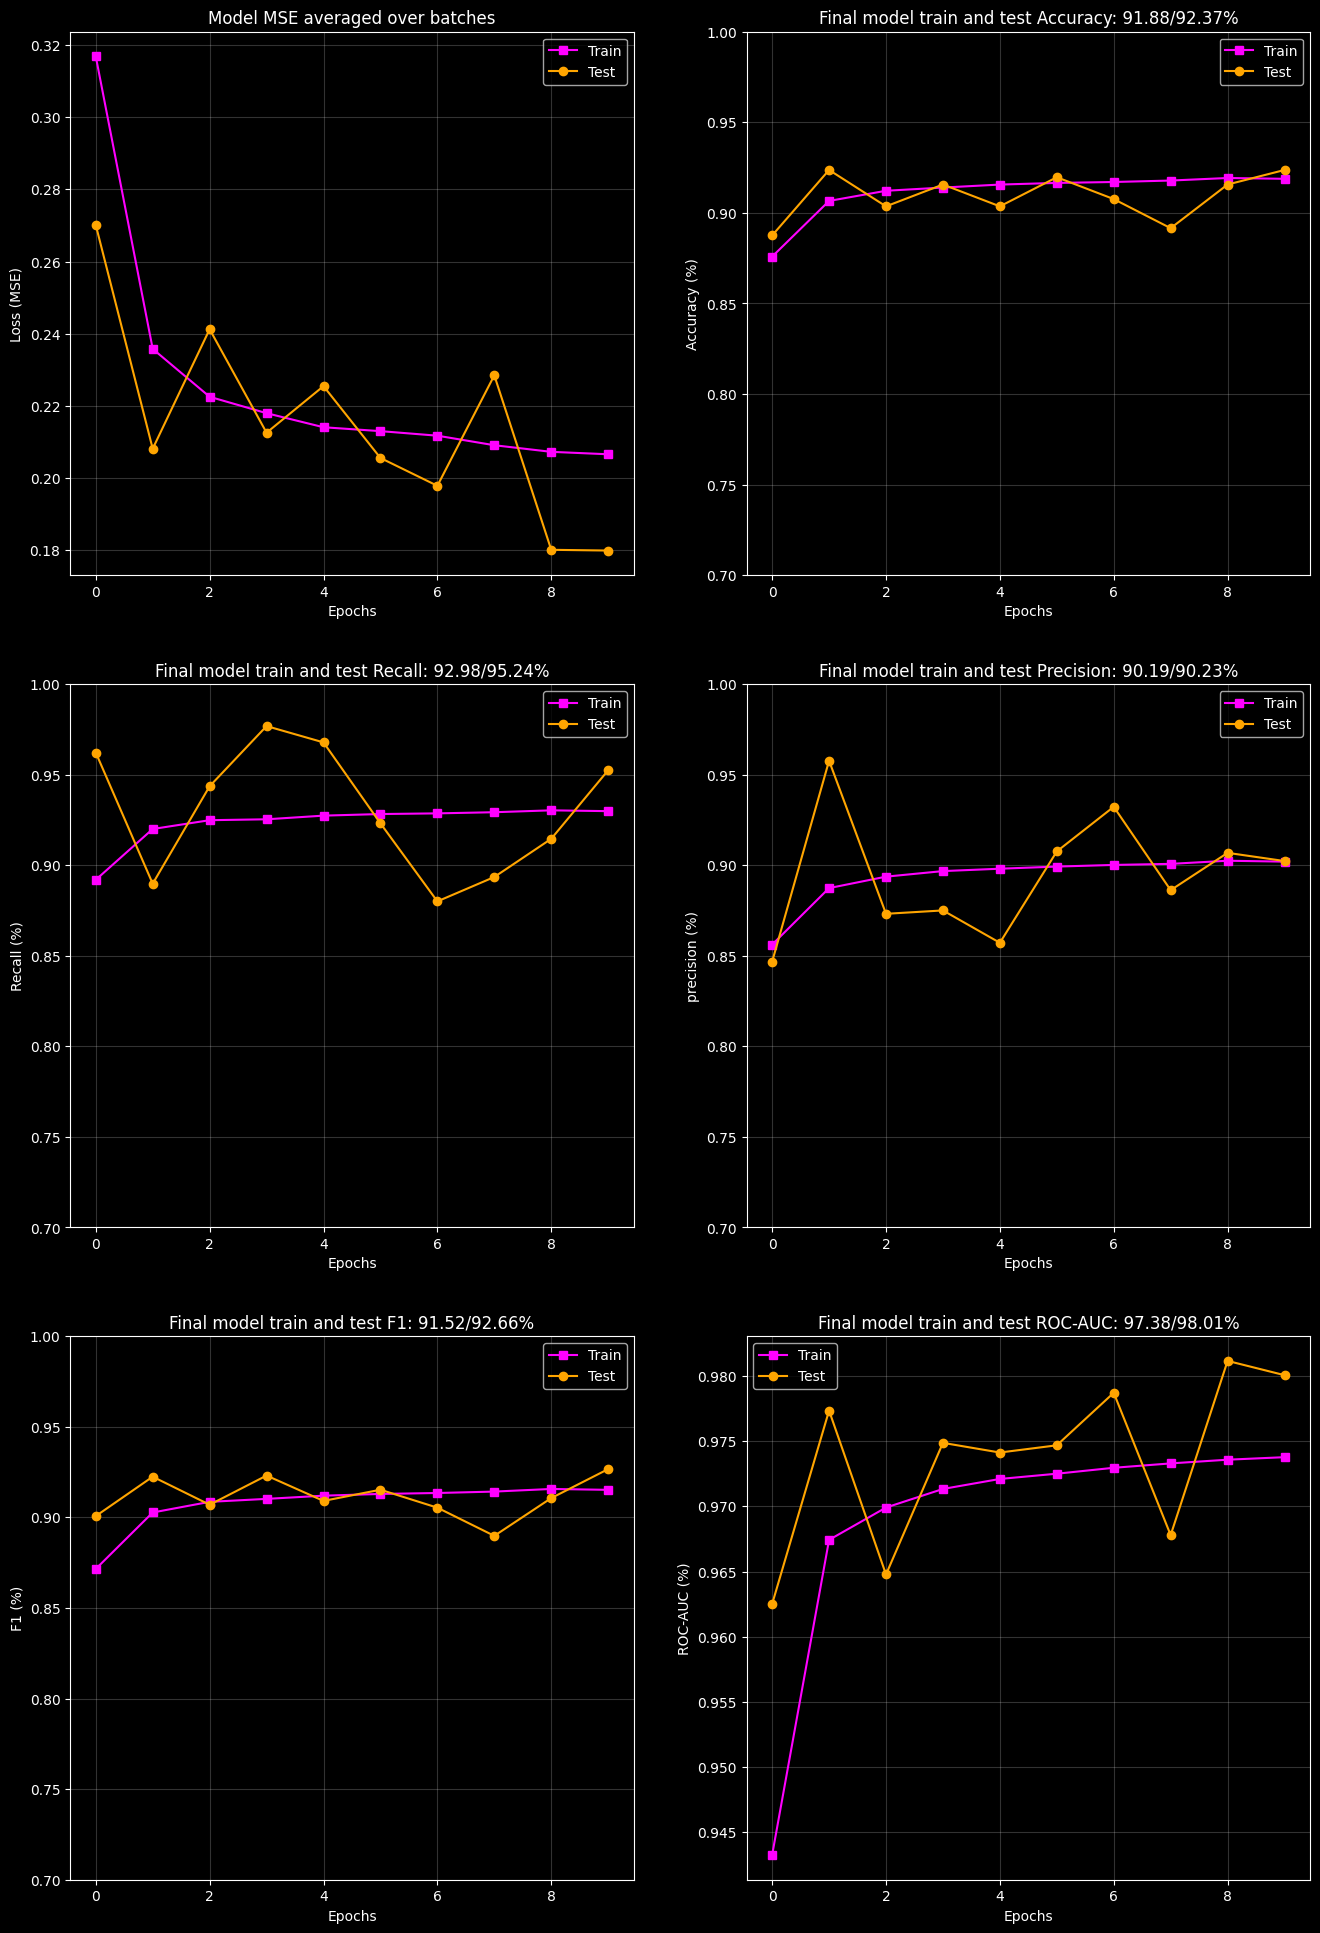

In [32]:
plt.style.use('dark_background')
fig, ax = plt.subplots(3, 2, figsize=(16, 24))

ax[0, 0].plot(trainLoss, 's-', label='Train', color='magenta')
ax[0, 0].plot(testLoss, 'o-', label='Test', color='orange')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss (MSE)')
ax[0, 0].set_title('Model MSE averaged over batches')
ax[0, 0].legend()
ax[0, 0].grid(alpha=0.2)

ax[0, 1].plot(trainAcc, 's-', label='Train', color='magenta')
ax[0, 1].plot(testAcc, 'o-', label='Test', color='orange')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Accuracy (%)')
ax[0, 1].set_title(f'Final model train and test Accuracy: {trainAcc[-1]*100:.2f}/{testAcc[-1]*100:.2f}%')
ax[0, 1].set_ylim(0.7, 1)
ax[0, 1].legend()
ax[0, 1].grid(alpha=0.2)

ax[1, 0].plot(trainRecall, 's-', label='Train', color='magenta')
ax[1, 0].plot(testRecall, 'o-', label='Test', color='orange')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Recall (%)')
ax[1, 0].set_title(f'Final model train and test Recall: {trainRecall[-1]*100:.2f}/{testRecall[-1]*100:.2f}%')
ax[1, 0].set_ylim(0.7, 1)
ax[1, 0].legend()
ax[1, 0].grid(alpha=0.2)

ax[1, 1].plot(trainPrecision, 's-', label='Train', color='magenta')
ax[1, 1].plot(testPrecision, 'o-', label='Test', color='orange')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('precision (%)')
ax[1, 1].set_title(f'Final model train and test Precision: {trainPrecision[-1]*100:.2f}/{testPrecision[-1]*100:.2f}%')
ax[1, 1].set_ylim(0.7, 1)
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.2)

ax[2, 0].plot(trainF1, 's-', label='Train', color='magenta')
ax[2, 0].plot(testF1, 'o-', label='Test', color='orange')
ax[2, 0].set_xlabel('Epochs')
ax[2, 0].set_ylabel('F1 (%)')
ax[2, 0].set_title(f'Final model train and test F1: {trainF1[-1]*100:.2f}/{testF1[-1]*100:.2f}%')
ax[2, 0].set_ylim(0.7, 1)
ax[2, 0].legend()
ax[2, 0].grid(alpha=0.2)

ax[2, 1].plot(trainROC, 's-', label='Train', color='magenta')
ax[2, 1].plot(testROC, 'o-', label='Test', color='orange')
ax[2, 1].set_xlabel('Epochs')
ax[2, 1].set_ylabel('ROC-AUC (%)')
ax[2, 1].set_title(f'Final model train and test ROC-AUC: {trainROC[-1]*100:.2f}/{testROC[-1]*100:.2f}%')
# ax[2, 1].set_ylim(0, 100)
ax[2, 1].legend()
ax[2, 1].grid(alpha=0.2)


plt.savefig('/kaggle/working/performance.png')
plt.show()

In [34]:
torch.save(resnet18.state_dict(), '/kaggle/working/resnet-18-oct-5metrics-v1.pt')

## **RESNET-50**

In [ ]:
# Download Pre-Trained RESNET-50 model
resnet50 = torchvision.models.resnet50(weights='IMAGENET1K_V1')
resnet50

In [ ]:
# Summarize and Inspect Model Parameters
summary(resnet50.to(device), (3, 224, 224))

In [ ]:
# Freeze all layers except feed forward layers
for name, param in resnet50.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

In [ ]:
# Modify the final layer
resnet50.fc = nn.Linear(2048, 2)

In [ ]:
# Push the model to the GPU if available
resnet50.to(device)

In [ ]:
# Define Loss Function and Optimizer
lossfun50 = nn.CrossEntropyLoss()
optimizer50 = torch.optim.Adam(resnet50.parameters(), lr=0.001)

In [ ]:
# test the model with one batch
X, y = next(iter(train_loader))
yHat = resnet50(X.to(device))

# check size of output
print('\Output size:')
print(yHat.shape)

# compute loss
loss = lossfun50(yHat, y.to(device))
print('\nLoss: ')
print(loss)

In [ ]:
# Train the Model
trainLoss, testLoss, trainAcc, testAcc, resnet50 = train_the_model(resnet50, lossfun50, optimizer50)

In [ ]:
# Visualize the Performance
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model MSE')
ax[0].grid(alpha=0.2)

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train and test Accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].set_ylim(50, 100)
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.show()

## **VGG-16**

In [37]:
vgg16 = torchvision.models.vgg16(weights='IMAGENET1K_V1')
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.7MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
summary(vgg16.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [39]:
# Freeze all layers except feed forward layers
for name, param in vgg16.named_parameters():
    if name not in ['classifier.weight', 'classifier.bias']:
        param.requires_grad = False

In [40]:
# Replace the final layer
vgg16.classifier[6] = nn.Linear(4096, 2)

In [41]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
lossfunv16 = nn.CrossEntropyLoss()
optimizerv16 = torch.optim.Adam(vgg16.parameters(), lr=0.001)

In [ ]:
# test the model with one batch
X, y = next(iter(train_loader))
yHat = vgg16(X.to(device))

# check size of output
print('\Output size:')
print(yHat.shape)

# compute loss
loss = lossfunv16(yHat, y.to(device))
print('\nLoss: ')
print(loss)

In [44]:
trainLoss, testLoss, trainAcc, testAcc, trainRecall, testRecall, trainPrecision, testPrecision, trainF1, testF1, vgg16 = train_the_model(vgg16, lossfunv16, optimizerv16)

Completed 47/211

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model MSE')
ax[0].grid(alpha=0.2)

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train and test Accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].set_ylim(50, 100)
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.show()

## **VGG-19**

In [35]:
vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')
vgg19

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:13<00:00, 43.6MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [36]:
summary(vgg19.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [37]:
# Freeze all layers except feed forward layers
for name, param in vgg19.named_parameters():
    if name not in ['classifier.weight', 'classifier.bias']:
        param.requires_grad = False

In [38]:
# Replace the final layer
vgg19.classifier[6] = nn.Linear(4096, 2)

In [39]:
vgg19.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [41]:
# Calculations for weighted loss function
class_weights = []
total_samples = len(train_data)

for i in range(len(train_data.classes)):
    class_samples = train_data.targets.count(i)
    weight_i = total_samples / (len(train_data.classes) * class_samples)
    class_weights.append(weight_i)
class_weights

[0.9472703738039847, 1.0589460305044975]

In [42]:
lossfunv19 = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
optimizerv19 = torch.optim.Adam(vgg19.parameters(), lr=0.001)

In [ ]:
# # test the model with one batch
# X, y = next(iter(train_loader))
# yHat = vgg19(X.to(device))

# # check size of output
# print('\Output size:')
# print(yHat.shape)

# # compute loss
# loss = lossfunv19(yHat, y.to(device))
# print('\nLoss: ')
# print(loss)

In [43]:
trainLoss, testLoss, trainAcc, testAcc, trainRecall, testRecall, trainPrecision, testPrecision, trainF1, testF1, trainROC, testROC, vgg19 = train_the_model(vgg19, lossfunv19, optimizerv19)

Completed 1/2/211 Epoch 1/10
Completed 1/2/211 Epoch 2/10
Completed 1/2/211 Epoch 3/10
Completed 1/2/211 Epoch 4/10
Completed 1/2/211 Epoch 5/10
Completed 1/2/211 Epoch 6/10
Completed 1/2/211 Epoch 7/10
Completed 1/2/211 Epoch 8/10
Completed 1/2/211 Epoch 9/10
Completed 1/2/211 Epoch 10/10


In [44]:
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

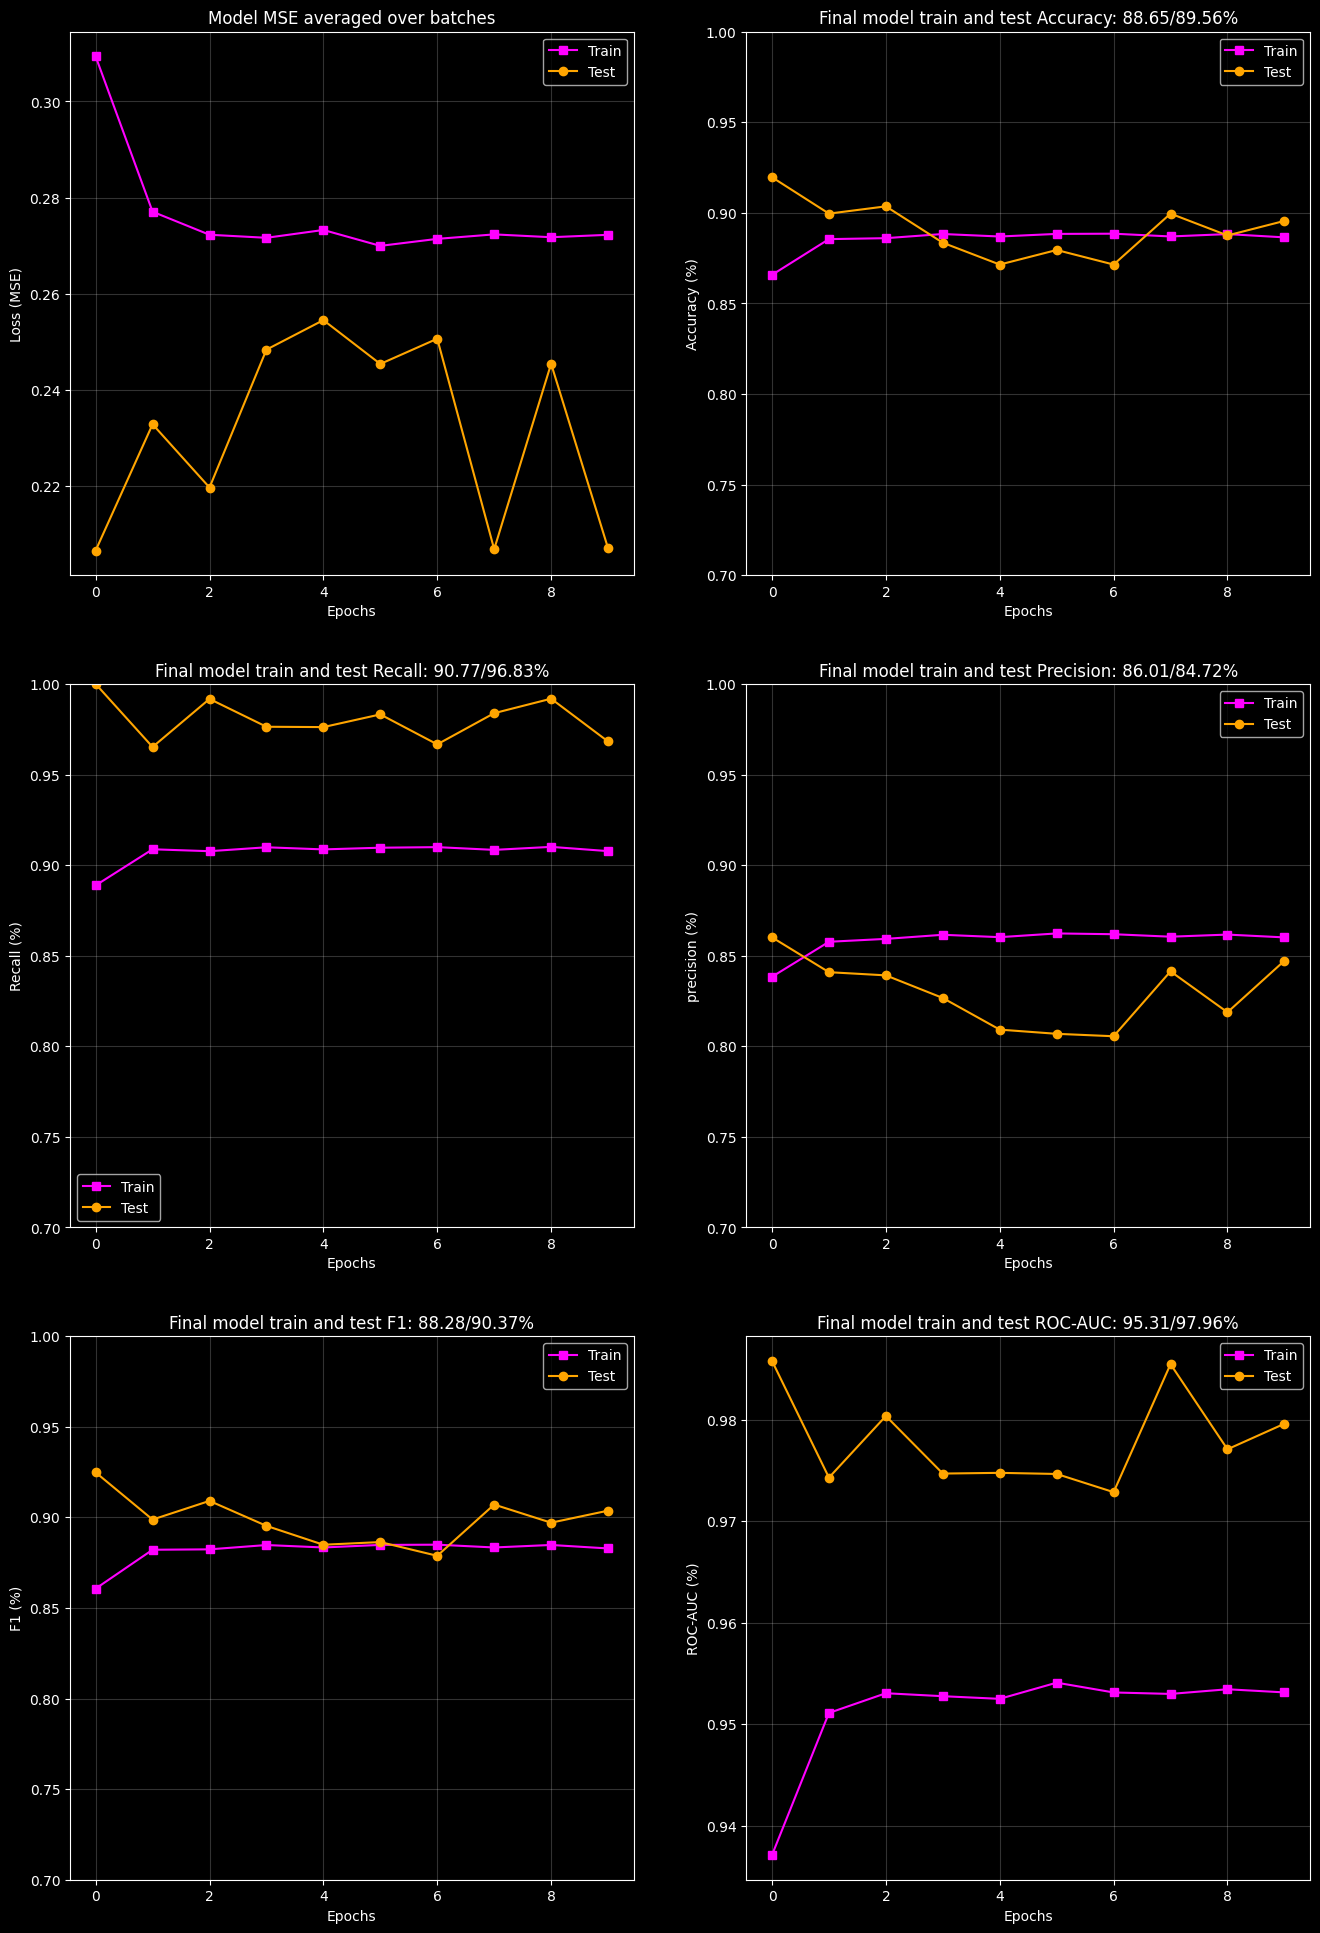

In [45]:
plt.style.use('dark_background')
fig, ax = plt.subplots(3, 2, figsize=(16, 24))

ax[0, 0].plot(trainLoss, 's-', label='Train', color='magenta')
ax[0, 0].plot(testLoss, 'o-', label='Test', color='orange')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss (MSE)')
ax[0, 0].set_title('Model MSE averaged over batches')
ax[0, 0].legend()
ax[0, 0].grid(alpha=0.2)

ax[0, 1].plot(trainAcc, 's-', label='Train', color='magenta')
ax[0, 1].plot(testAcc, 'o-', label='Test', color='orange')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Accuracy (%)')
ax[0, 1].set_title(f'Final model train and test Accuracy: {trainAcc[-1]*100:.2f}/{testAcc[-1]*100:.2f}%')
ax[0, 1].set_ylim(0.7, 1)
ax[0, 1].legend()
ax[0, 1].grid(alpha=0.2)

ax[1, 0].plot(trainRecall, 's-', label='Train', color='magenta')
ax[1, 0].plot(testRecall, 'o-', label='Test', color='orange')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Recall (%)')
ax[1, 0].set_title(f'Final model train and test Recall: {trainRecall[-1]*100:.2f}/{testRecall[-1]*100:.2f}%')
ax[1, 0].set_ylim(0.7, 1)
ax[1, 0].legend()
ax[1, 0].grid(alpha=0.2)

ax[1, 1].plot(trainPrecision, 's-', label='Train', color='magenta')
ax[1, 1].plot(testPrecision, 'o-', label='Test', color='orange')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('precision (%)')
ax[1, 1].set_title(f'Final model train and test Precision: {trainPrecision[-1]*100:.2f}/{testPrecision[-1]*100:.2f}%')
ax[1, 1].set_ylim(0.7, 1)
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.2)

ax[2, 0].plot(trainF1, 's-', label='Train', color='magenta')
ax[2, 0].plot(testF1, 'o-', label='Test', color='orange')
ax[2, 0].set_xlabel('Epochs')
ax[2, 0].set_ylabel('F1 (%)')
ax[2, 0].set_title(f'Final model train and test F1: {trainF1[-1]*100:.2f}/{testF1[-1]*100:.2f}%')
ax[2, 0].set_ylim(0.7, 1)
ax[2, 0].legend()
ax[2, 0].grid(alpha=0.2)

ax[2, 1].plot(trainROC, 's-', label='Train', color='magenta')
ax[2, 1].plot(testROC, 'o-', label='Test', color='orange')
ax[2, 1].set_xlabel('Epochs')
ax[2, 1].set_ylabel('ROC-AUC (%)')
ax[2, 1].set_title(f'Final model train and test ROC-AUC: {trainROC[-1]*100:.2f}/{testROC[-1]*100:.2f}%')
# ax[2, 1].set_ylim(0, 100)
ax[2, 1].legend()
ax[2, 1].grid(alpha=0.2)


plt.savefig('/kaggle/working/performance-vgg19.png')
plt.show()

In [46]:
torch.save(vgg19.state_dict(), '/kaggle/working/vgg19-oct-5metrics-v1.pt')